An overview of the German electricity prices
=======

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
!pip install -q statsmodels

data_file_path = 'Germany.csv'
dataframe = pd.read_csv(data_file_path)
dataframe['Datetime (UTC)'] = pd.to_datetime(dataframe['Datetime (UTC)']) # Wir konvertieren das datum in ein Datenformat
dataframe = dataframe.sort_values(by='Datetime (UTC)')
dataframe.index = pd.to_datetime(dataframe['Datetime (UTC)'])

## Initial observations
The SMARD Data for Germany contains hourly prices ranging from the first of January 2015 to the first of April, making up a total of 81'073 data points. Inspecting the price given in €/MWhe, various interesting observations can be made:
- Negative electricity prices exist. This occured a total of 1606 times, with the price being exactly 0€ 65 times. 
- The lowest recorded price in the data set was -500€, occuring at 2022-08-23 20:00:00. The second lowest price with -399€ was achieved the same day. These are stark outliers, with only 13 entries below the -100€ mark. The sum being exactly 500.00€ in particular stands out as peculiar.
- The highest recorded price in the data set was 1047.11€, occurring at  2023-07-02 14:00:00. In total, only 5 entries surpass the 900€ mark, all of them past 2023. 

In [140]:
print(dataframe.sort_values(by=['Price (EUR/MWhe)']))

                     Country ISO3 Code      Datetime (UTC)  \
Datetime (UTC)                                               
2023-07-02 12:00:00  Germany       DEU 2023-07-02 12:00:00   
2023-07-02 13:00:00  Germany       DEU 2023-07-02 13:00:00   
2023-07-02 11:00:00  Germany       DEU 2023-07-02 11:00:00   
2023-07-02 10:00:00  Germany       DEU 2023-07-02 10:00:00   
2023-01-16 04:00:00  Germany       DEU 2023-01-16 04:00:00   
...                      ...       ...                 ...   
2022-09-19 18:00:00  Germany       DEU 2022-09-19 18:00:00   
2022-08-26 18:00:00  Germany       DEU 2022-08-26 18:00:00   
2022-08-29 20:00:00  Germany       DEU 2022-08-29 20:00:00   
2022-08-24 18:00:00  Germany       DEU 2022-08-24 18:00:00   
2022-08-23 18:00:00  Germany       DEU 2022-08-23 18:00:00   

                        Datetime (Local)  Price (EUR/MWhe)  
Datetime (UTC)                                              
2023-07-02 12:00:00  2023-07-02 14:00:00           -500.00  
2023-07-02

# Explaining negative values
Negative wholesale electricity prices are a phenomenon that arises when high and inflexible electricity generation, frequently from renewable sources such as wind and solar, coincides with low demand, particularly during periods of low consumption such as holidays. During these times, producers are remunerated for offloading excess electricity, which results in negative prices. This typically occurs when renewable generation exceeds demand, as evidenced by the case of Easter Monday 2019 in Germany, where the country's entire electricity needs were met by renewable energy production.
Further information can be found on the smard website itself.
https://www.smard.de/page/en/wiki-article/5884/105426

## Initial Plotting
An initial plotting of the entire data immediatly draws attention to the uniformity of the graph prior to the second half of 2021 compared to the much larger variance in the latter part of the diagram. There are also notable individual spikes, again particularly from the latter half of 2021 onwards. 

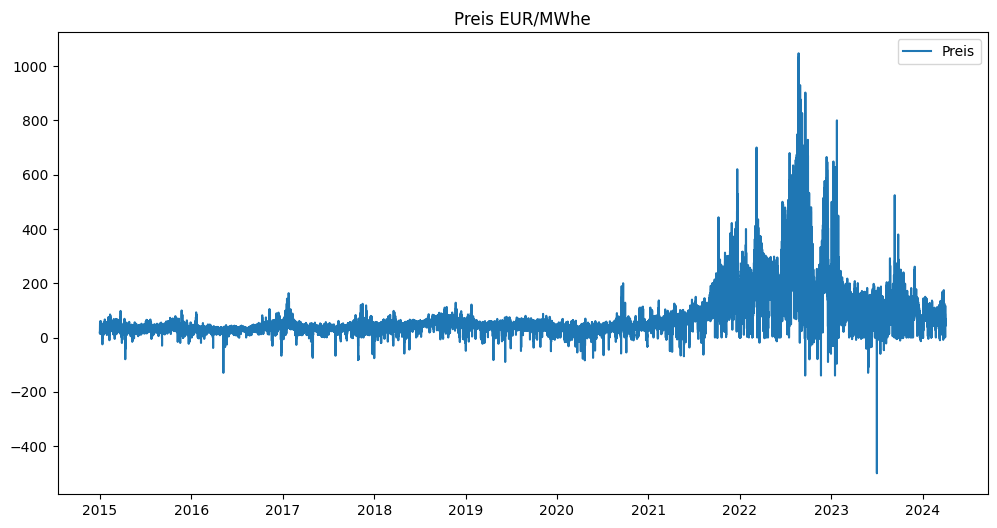

In [141]:
plt.figure(figsize=(12,6))
plt.plot(dataframe['Datetime (UTC)'], dataframe['Price (EUR/MWhe)'], label='Preis')
plt.legend()
plt.title('Preis EUR/MWhe')
plt.show()


# Smaller Trends with seasonal decompose
However, at this scale, the data might not be very indicative. To gain further insight, a simple decomposition is done on the span of the last four weeks. 
Here, the seasonal window clearly shows each day, with 28 distinct repeating patterns, showcasing the individual days and indicating a strong dailiy cycle. The trend window on the other hand, indicates a lowered prices on weekends. 

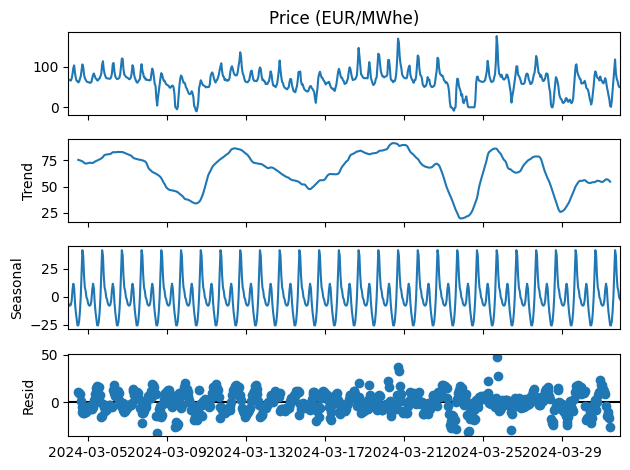

In [142]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = dataframe['Price (EUR/MWhe)']
#24 *7 * 4 = 672 
result = seasonal_decompose(series[-672:], model='additive')
result.plot()
plt.show()


## Plotting these trends

### Week
First, let us examine the daily trend over the course of a week. By averaging the values of the entire data set per weekday, it becomes evident that there is a clear downward trend in prices over the weekend, with Sunday in particular being a low point. This can be speculated to be related to lowered consumption. 

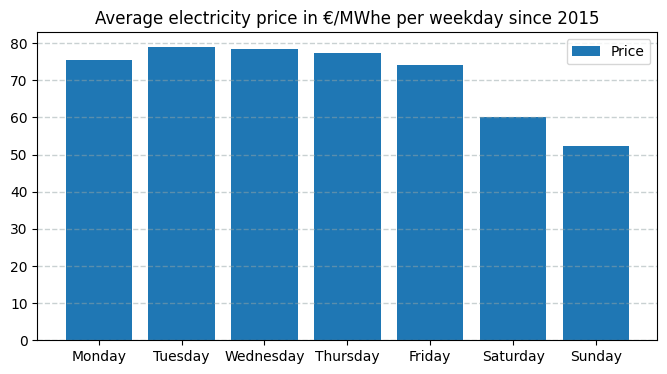

In [143]:
dataframe.set_index('Datetime (UTC)')
weekday_mean_frame = dataframe.groupby(dataframe["Datetime (UTC)"].dt.weekday)['Price (EUR/MWhe)'].mean()

plt.figure(figsize=(8,4))
plt.bar(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], weekday_mean_frame, label='Price')
plt.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.5)
plt.legend()
plt.title('Average electricity price in €/MWhe per weekday since 2015')
plt.show()

### Months
Averaging the months of the year, a further difference is visible. This can be speculated to both pertain to temperatures and therefore heating and weather influences. 

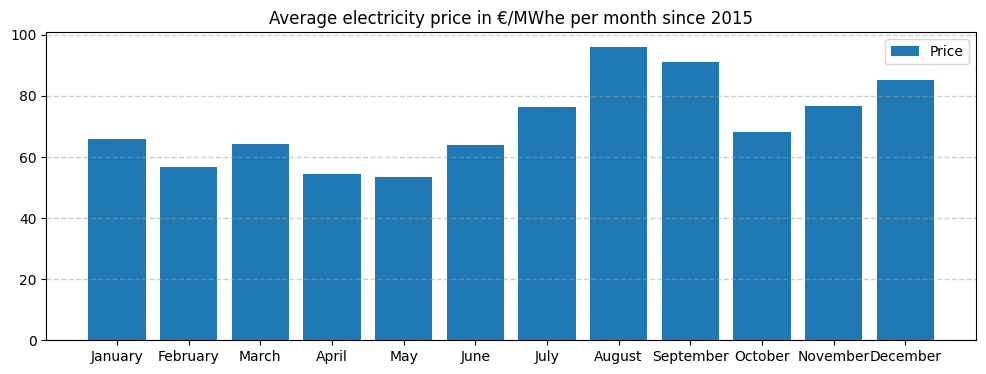

In [144]:
dataframe.set_index('Datetime (UTC)')
monthly_mean_frame = dataframe.groupby(dataframe["Datetime (UTC)"].dt.month)['Price (EUR/MWhe)'].mean()

plt.figure(figsize=(12,4))
plt.bar(["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], monthly_mean_frame, label='Price')
plt.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.5)
plt.legend()
plt.title('Average electricity price in €/MWhe per month since 2015')
plt.show()

### Years
Averaging the individual years, a striking spike during the year 2022 stands out. A slight increase due to inflation is to be expected, however the spike clearly superceeds the inflation of 7,9% that year. Inflation data is taken from https://www.finanz-tools.de/inflation/inflationsraten-deutschland

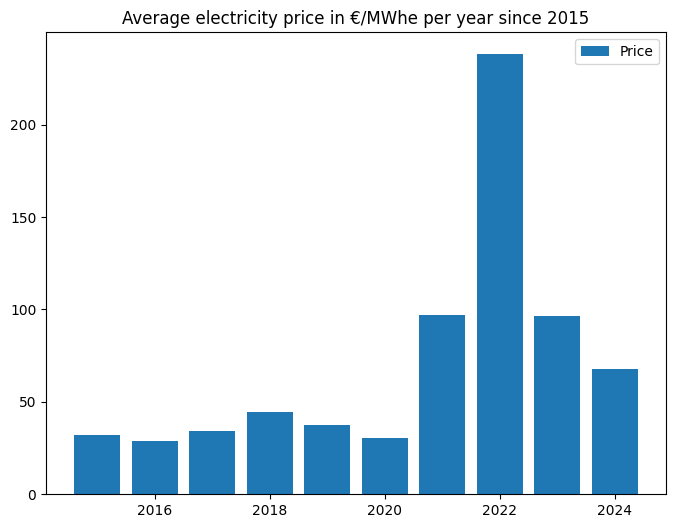

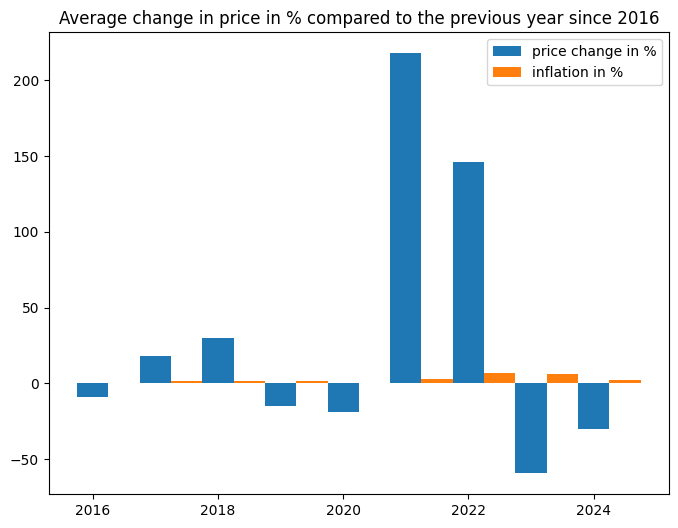

In [145]:
dataframe.set_index('Datetime (UTC)')
yearly_mean_frame = dataframe.groupby(dataframe["Datetime (UTC)"].dt.year)['Price (EUR/MWhe)'].mean()

plt.figure(figsize=(8,6))
plt.bar([2015,2016,2017,2018,2019,2020,2021,2022,2023,2024], yearly_mean_frame, label='Price')
plt.legend()
plt.title('Average electricity price in €/MWhe per year since 2015')
plt.show()

previous_year_price = yearly_mean_frame[2015]
price_changes = []
for yearly_price in yearly_mean_frame:
    if yearly_price != yearly_mean_frame[2015]:
        price_changes.append (yearly_price / previous_year_price * 100 -100)
        previous_year_price = yearly_price

inflation_from_2016 = [0.5, 1.5, 1.8, 1.4, 0.5, 3.1, 6.9, 5.9, 2.2]
plt.figure(figsize=(8,6))
plt.bar([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024], price_changes, width=0.5,label='price change in %')
plt.bar([2016+0.5, 2017+0.5, 2018+0.5, 2019+0.5, 2020+0.5, 2021+0.5, 2022+0.5, 2023+0.5, 2024+0.5], inflation_from_2016, width=0.5,label='inflation in %')
plt.legend()
plt.title('Average change in price in % compared to the previous year since 2016')
plt.show()

# Limitations of the Data
## Market change
The precise definition of the German energy price has undergone alterations throughout the entirety of the data set. In particular, it is necessary to determine which entities are included and which are excluded.
Up until October 2018, Germany constituted a unified market with both Luxembourg and Austria. 
However, in a move that was met with disapproval by the Austrian government, the integrated market was dismantled as a result of political decisions and now only includes Germany and Luxembourg.
See https://www.politico.eu/article/germany-austria-energy-europe-power-couple-break-up/

## Erroneous calculations
On June 26, 2024, the day-ahead price was not correctly calculated, resulting in a lower price than it should have been. This affected customers using dynamic pricing tariffs to a significant extent. 
See https://de.wikipedia.org/wiki/EPEX_Spot_Dayahead_Auktion#Vorkommnis
